In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely import Point
from joblib import Parallel, delayed as delayed_joblib

import dask
from dask.distributed import Client, LocalCluster
from dask import delayed

import matplotlib.pyplot as plt

In [2]:
# if "client" not in locals():
#     cluster = LocalCluster(n_workers=32, threads_per_worker=1)
#     client = Client(cluster)

# client

In [3]:
base_path = "/home/patel_zeel/OpenAQ/PurpleAir/purpleair_california.nc"
ds = xr.open_dataset(base_path, chunks="auto").load()
ds

<xarray.Dataset>
Dimensions:      (datetime: 44350, location_id: 11618)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-03-25T18:00:00 ... 2023-04-16...
  * location_id  (location_id) int64 61935 61938 61942 ... 1637277 1658374
    lat          (location_id) float64 33.94 38.37 37.57 ... 40.02 39.55 34.04
    lon          (location_id) float64 -117.4 -122.5 -122.3 ... -123.4 -118.3
Data variables:
    value        (datetime, location_id) float64 nan nan nan nan ... nan nan nan

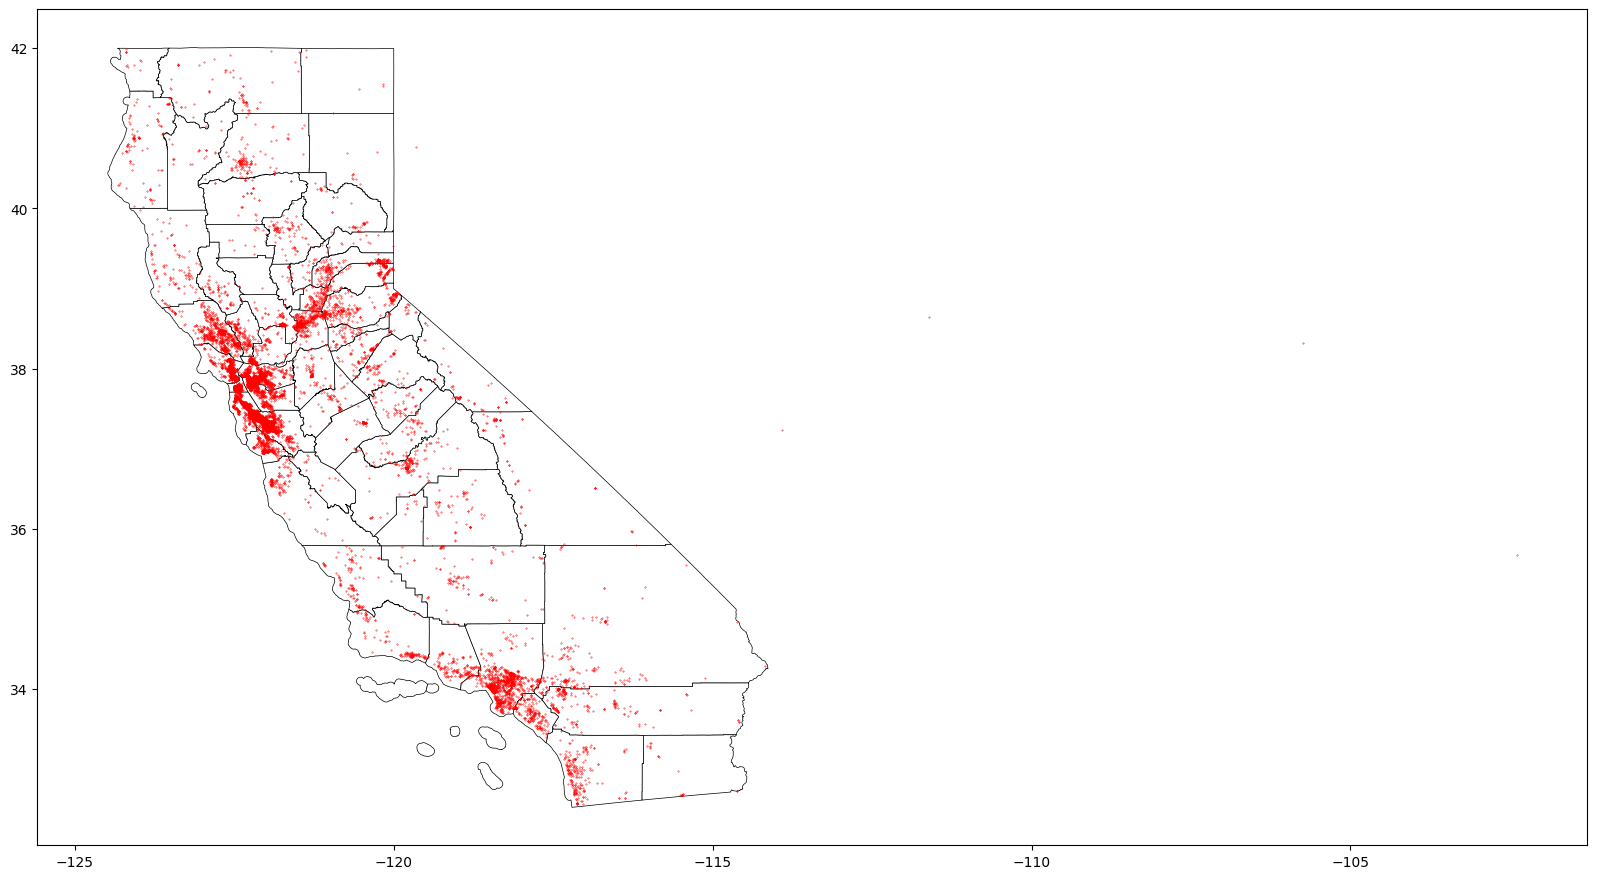

In [4]:
cal_map = gpd.read_file("/home/patel_zeel/aqmsp/aqmsp_data/datasets/shapefiles/california/CA_Counties_TIGER2016.shp")
# convert to lat/lon
cal_map = cal_map.to_crs(epsg=4326)

# fig, ax = plt.subplots(1, 2)
# cal_map.plot(ax=ax[0], color='white', edgecolor='black', linewidth=0.5)
cal_map.plot(color='white', edgecolor='black', linewidth=0.5, figsize=(20, 20))

# plot lat/lon
plt.scatter(ds['lon'], ds['lat'], s=0.1, c='red')

<AxesSubplot:>

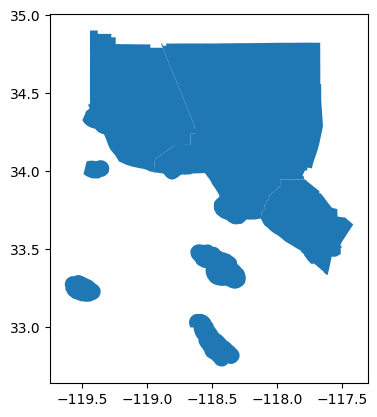

In [5]:
cities = ["Los Angeles", "Orange", "Ventura"]
la_map = cal_map[cal_map.NAME.isin(cities)]
la_map.plot()

In [6]:
# find all points in LA by using the lat/lon
unary = la_map.geometry.unary_union

def find_points_in_la(lon, lat, id):
    if unary.contains(Point(lon, lat)):
        return id.item()
    else:
        return None

la_stations = Parallel(32)([delayed_joblib(find_points_in_la)(lon, lat, id) for lon, lat, id in zip(ds['lon'], ds['lat'], ds['location_id'])])
la_stations = [x for x in la_stations if x is not None]
len(la_stations)
# la_map.geometry.unary_union.contains(Point(-118.243683, 34.052235))

1301

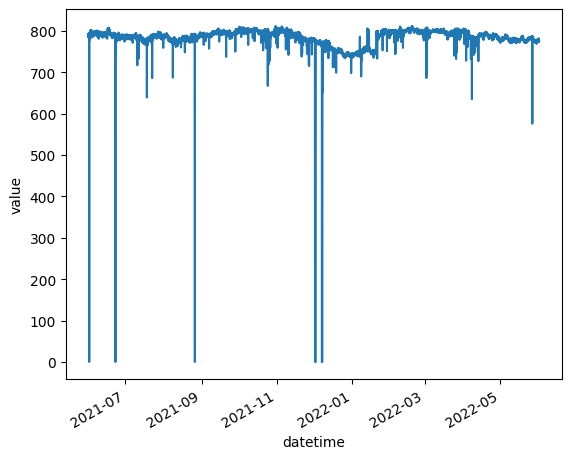

In [7]:
la_ds = ds.sel(location_id=la_stations, datetime = slice('2021-06-01', '2022-06-01'))
# convert location_id to string
la_ds['location_id'] = la_ds['location_id'].astype(str)

# plot number of stations which have non-null values for each time
la_ds["value"].notnull().sum(dim='location_id').plot()

In [8]:
dense_ds = ((la_ds["value"].notnull().sum(dim='datetime') / len(la_ds["datetime"])) > 0.95)
# drop False values
dense_ds = dense_ds[dense_ds]
dense_ds

<xarray.DataArray 'value' (location_id: 493)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
Coordinates:
  * location_id  (location_id) <U21 '62194' '62203' ... '227551' '227806'
    lat          (location_id) float64 34.07 33.86 33.84 ... 34.07 34.07 34.0
    lon          (location_id) float64 -118.2 -118.4 -118.3 ... -118.2 -118.1

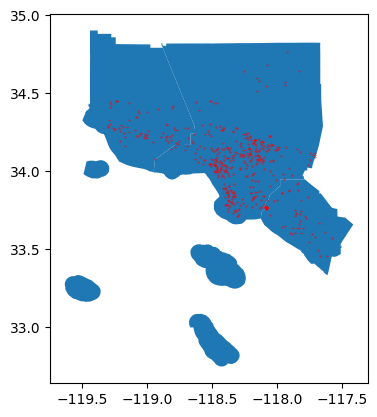

In [9]:
fig, ax = plt.subplots()
la_map.plot(ax=ax)

ax.scatter(dense_ds['lon'], dense_ds['lat'], s=0.1, c='red')

In [10]:
dense_ds.to_netcdf(os.path.join("../data/", "_".join(cities)+".nc"))